Notebook to determine the noise level in AZKABAN during zooplankton experiment January 2022 in Ny-Ålesund

In [66]:
import csv
import os
from datetime import timedelta
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import matplotlib.dates as mdates
import warnings
%matplotlib inline

In [2]:
sns.set_theme(style="whitegrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

warnings.simplefilter("ignore")

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16



## Analysis
In Echoview, Single Echo Detection + 0.07m mask on TS data, only noise left.

Export TS (nominal frequency) of noise.

In [3]:
#Read file
fname = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Noise_TS.csv'


time_cols = [0,4,5]
noise_TS = pd.read_csv(fname,header=None, skiprows=1,index_col = 0)#, usecols=np.append(time_cols,TS_cols))


### Make datetime array

In [4]:
times=[]
for ind in range(0,len(noise_TS)):
            times = np.append(times, datetime.strptime('%s.%s' %(noise_TS[4].values[ind],int(noise_TS[5].values[ind])), '%H:%M:%S.%f'))


### Read TS data

In [5]:
start = 15
n_bins = np.shape(noise_TS)[1]-start

TS_cols = np.arange(start,n_bins+start)

In [6]:
depth = pd.read_csv(fname,header=None, skiprows=1, usecols=[8,9], nrows=1)
start_range = depth[8][0]
end_range = depth[9][0]
d_range = (end_range-start_range)/(n_bins-2)
TS_data = pd.read_csv(fname,header=None, skiprows=1,index_col = 0, usecols=TS_cols)
TS_data_thres = np.where(TS_data<-999,np.nan,TS_data) # Change -999 to NaN

### Plot data

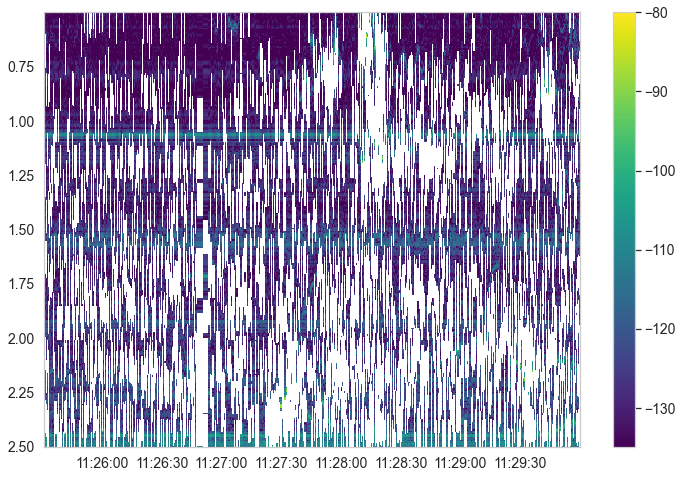

In [7]:
plt.figure(figsize=(12,8))
plt.pcolormesh(times,np.linspace(start_range, end_range,n_bins-1),TS_data_thres.T, cmap="viridis")
plt.clim([-135,-80])
plt.gca().invert_yaxis()
plt.colorbar()

### Project to range axis only (median across time) and smooth
use a 0.1 m depth filter

In [8]:
N = 18  #0.1m/d_range

conv_TS = np.convolve(np.nanmedian(TS_data_thres,0), np.ones(N)/N, mode='full')
smooth_TS = conv_TS[N:-N]

In [9]:
depth_range = np.linspace(start_range, end_range,n_bins-1)
edge = int(N/2)
depth_smooth = depth_range[edge:-edge-1]

### plot noise profile with used range limits indicated

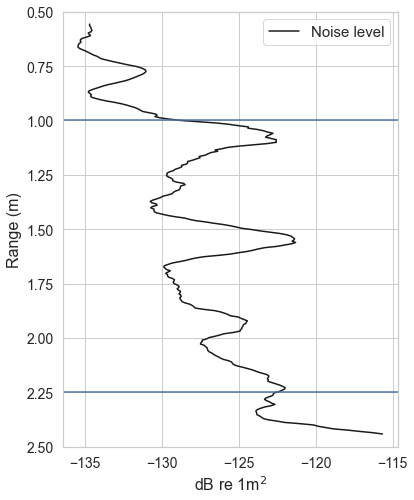

In [10]:
plt.figure(figsize=(6,8))
plt.plot(smooth_TS, depth_smooth, 'r-', label='Noise level')
plt.axhline(1)
plt.axhline(2.25)
plt.ylim([0.5,2.5])
plt.xlabel('dB re 1m$^2$')
plt.ylabel('Range (m)')
plt.legend(fontsize=15)
plt.gca().invert_yaxis()

### Export to file 

In [11]:
noise_df = pd.DataFrame({'range':depth_smooth,'TS':smooth_TS})
noise_df = noise_df.reset_index()

In [12]:
noise_df.to_feather('Noise_AZKABAN_200kHz.feather')

# Read SED
Compare TS from SEDs with regular parameters to the noise level

In [13]:
def tsf_import(file_path):

    """
    This function imports wideband frequency response .csv files exported from
    Echoview and performs some basic housekeeping.
    
    PARAMETERS:
        file_path: Path to wideband frequency response .csv file from Echoview.
        
    RETURNS:
        df: Pandas dataframe.
    """
    
    def get_datetime(df):
        """
        Convert Echoview timestamps in imported .csv to datetime.
        """
        df['Ping_microseconds'] = df.Ping_milliseconds * 1000
        df['Ping_microseconds'] = [timedelta(microseconds = i) for i in df['Ping_microseconds']]
        df['Datetime'] = df['Ping_date_Ping_time'] + df['Ping_microseconds']
        df.drop(columns=['Ping_date_Ping_time',
                         'Ping_milliseconds',
                         'Ping_microseconds'],
               inplace=True)
        
        return df
    
    transposed_path = file_path[:-4] + '_transposed.csv'
    if os.path.isfile(transposed_path) == True:
        df = pd.read_csv(transposed_path,
                         index_col='Target_index',
                         skiprows=1,
                         skipfooter=2,
                         engine='python',
                         parse_dates=[['Ping_date', 'Ping_time']])
    else:
        df = pd.read_csv(file_path, low_memory=False).T
        file_path = transposed_path
        df.to_csv(path_or_buf=file_path)
        print('A transposed TS(f) file was created at: \n' + str(file_path))    
        df = pd.read_csv(file_path,
                         index_col='Target_index',
                         skiprows=1,
                         skipfooter=2,
                         engine='python',
                         parse_dates=[['Ping_date', 'Ping_time']])
    
    df = get_datetime(df)
    
    return df


In [14]:
SED_df = tsf_import('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/SED_ZoopMix_newcal.csv')

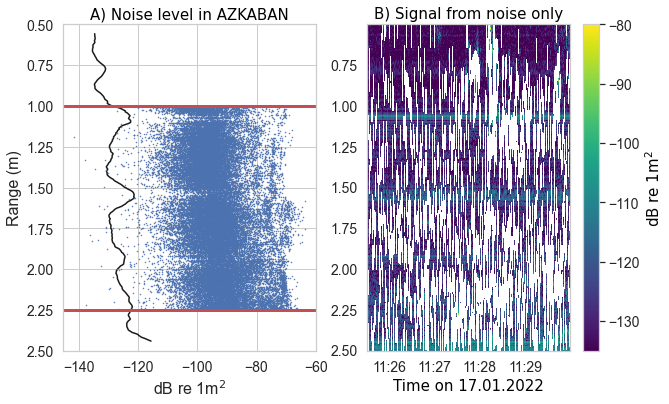

In [74]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(smooth_TS, depth_smooth, 'k-', label='Noise level')
plt.plot(SED_df['200.000'],SED_df['Range'], 'b.',markersize=1)
plt.axhline(y=1, c='r', linewidth=3)
plt.axhline(y=2.25, c='r', linewidth=3)
plt.ylim([0.5,2.5])
plt.xlabel('dB re 1m$^2$')
plt.ylabel('Range (m)')
#plt.legend(fontsize=15)
plt.title('A) Noise level in AZKABAN', title_font)
plt.gca().invert_yaxis()

ax = plt.subplot(1,2,2)
plt.pcolormesh(times,np.linspace(start_range, end_range,n_bins-1),TS_data_thres.T, cmap="viridis")
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlabel('Time on 17.01.2022', axis_font)
plt.clim([-135,-80])
plt.gca().invert_yaxis()
plt.title('B) Signal from noise only', title_font)
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB re 1m$^2$', axis_font);


In [26]:
SED_df

,Ping_index,Range,Depth,185.000,185.500,186.000,186.500,187.000,187.500,188.000,...,251.000,251.500,252.000,252.500,253.000,253.500,254.000,254.500,255.000,Datetime
Target_index,,,,,,,,,,,,,,,,,,,,,
0,0,1.715900,1.715748,-69.823493,-70.530866,-70.045650,-68.703572,-67.589486,-67.299204,-67.613790,...,-69.666348,-69.888520,-70.553844,-71.219605,-71.327529,-70.748430,-69.837927,-69.076749,-68.730971,2022-01-17 09:45:17.944
1,0,2.191251,2.191001,-72.575992,-74.251453,-76.253872,-77.647561,-77.474418,-76.641174,-76.217008,...,-82.833486,-81.858615,-82.543322,-82.304048,-81.020213,-81.090233,-83.382878,-85.490992,-82.334747,2022-01-17 09:45:17.944
2,1,1.715900,1.715689,-69.395608,-69.495457,-70.101281,-71.023900,-72.250249,-73.625475,-73.969567,...,-70.171229,-70.143635,-70.181097,-70.372350,-70.675931,-70.916721,-70.909437,-70.606489,-69.961449,2022-01-17 09:45:18.478
3,2,1.710103,1.709843,-70.970480,-72.333277,-73.727388,-74.001537,-72.767456,-70.840647,-69.164982,...,-70.649748,-71.150817,-71.203988,-70.764723,-70.172701,-69.684643,-69.367438,-69.274073,-69.335042,2022-01-17 09:45:18.881
4,3,1.692712,1.692449,-73.468971,-71.471289,-69.500600,-68.252118,-67.905025,-68.465909,-69.360354,...,-70.289131,-70.393430,-70.310327,-70.033694,-69.714868,-69.526391,-69.532318,-69.690656,-69.714074,2022-01-17 09:45:19.286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37972,28033,1.762276,1.759939,-115.379135,-119.053142,-116.160944,-114.204025,-108.749780,-106.003019,-106.816211,...,-129.986266,-112.468434,-108.399313,-110.708771,-126.051730,-109.982976,-107.034886,-109.480653,-108.446227,2022-01-17 12:54:21.103
37973,28034,1.078235,1.077697,-114.346038,-122.757011,-121.474552,-117.632925,-118.846959,-121.806300,-121.356256,...,-122.492998,-131.490956,-132.897026,-119.530174,-114.621584,-113.855158,-117.695146,-118.036459,-110.413739,2022-01-17 12:54:21.505
37974,28076,1.078235,1.077310,-112.592396,-110.607949,-109.657420,-111.049117,-115.563741,-123.471379,-121.405405,...,-114.523883,-111.473553,-114.567429,-124.084250,-114.612863,-113.930471,-125.667246,-113.696421,-108.057252,2022-01-17 12:54:38.405


In [28]:
SED = SED_df.to_numpy()
SED_TS = SED[:,3:-1]

In [34]:
SED[:,2]

array([1.7157477336, 2.1910008108, 1.7156888479, ..., 1.0773095796,
       1.0480232928, 1.5474290093], dtype=object)

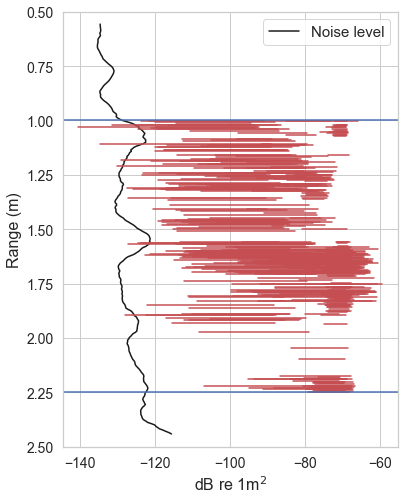

In [44]:
plt.figure(figsize=(6,8))
plt.plot(smooth_TS, depth_smooth, 'k-', label='Noise level')
for ind in range(500):
    plt.plot([np.min(SED_TS,1)[ind],np.max(SED_TS,1)[ind]],[SED[ind,2], SED[ind,2]], 'r-')
plt.axhline(1)
plt.axhline(2.25)
plt.ylim([0.5,2.5])
plt.xlabel('dB re 1m$^2$')
plt.ylabel('Range (m)')
plt.legend(fontsize=15)
plt.gca().invert_yaxis()


In [39]:
np.min(SED_TS,1)[ind]

-76.548392